<a href="https://colab.research.google.com/github/AbdullahNasser98/ChatBot-PyTorch/blob/master/ChatBot_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/makcedward/nlpaug.git

Cloning into 'nlpaug'...
remote: Enumerating objects: 5670, done.
remote: Counting objects: 100% (1197/1197), done.
remote: Compressing objects: 100% (355/355), done.
remote: Total 5670 (delta 853), reused 1144 (delta 833), pack-reused 4473
Receiving objects: 100% (5670/5670), 3.27 MiB | 13.71 MiB/s, done.
Resolving deltas: 100% (4015/4015), done.


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 14.0 MB/s 
     |████████████████████████████████| 6.6 MB 46.5 MB/s 
     |████████████████████████████████| 880 kB 74.4 MB/s 
     |████████████████████████████████| 596 kB 41.8 MB/s 
     |████████████████████████████████| 77 kB 7.3 MB/s 
     |████████████████████████████████| 96 kB 7.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.50-py3-none-any.whl size=895166 sha256=7a281c12f93422e59795fe3820f58ac7cd5a0d85432f1298083ec54f30b50cc6
  Stored in directory: /root/.cache/pip/wheels/d9/72/54/519f0d5143cc6c73fa3297509123c86fc8586a7fdea8d25311
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into 

In [ ]:
ls

nlpaug/  sample_data/


In [ ]:
######Generating Dataset#######
######Create Dataset###########
%%writefile /content/nlpaug/example/textual_augmenter.py

#import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
#import nlpaug.augmenter.sentence as nas
#import nlpaug.flow as nafc
import pandas as pd
#from nlpaug.util import Action

#aug = nas.ContextualWordEmbsForSentenceAug(model_path='gpt2')
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")


intents = ["greeting", "age", "date", "name", "goodbye"]
response_no = 20
questions = ['hello!', 'how old are you?', 'what is the date?', 'what is your name?', 'See you later']

data = pd.DataFrame(columns=['response', 'tag'])
counter = 0

for intent in range(len(intents)):
  for row in range(response_no):
    augmented_text = aug.augment(questions[intent])
    data.loc[row+counter] = [augmented_text, intents[intent]]
  counter = counter + 20
data.to_csv('/content/sample_data.csv', index=False)

Overwriting /content/nlpaug/example/textual_augmenter.py


In [ ]:
!python /content/nlpaug/example/textual_augmenter.py

Downloading: 100% 28.0/28.0 [00:00<00:00, 25.0kB/s]
Downloading: 100% 570/570 [00:00<00:00, 500kB/s]
Downloading: 100% 226k/226k [00:00<00:00, 684kB/s]
Downloading: 100% 455k/455k [00:00<00:00, 1.10MB/s]
Downloading: 100% 420M/420M [00:07<00:00, 56.9MB/s]


In [ ]:
# used a dictionary to represent an intents JSON file
data = {"intents": [
{"tag": "greeting",
 "responses": ["Howdy Partner!", "Hello", "How are you doing?",   "Greetings!", "How do you do?"]},
{"tag": "age",
 "responses": ["I am 25 years old", "I was born in 1998", "My birthday is July 3rd and I was born in 1998", "03/07/1998"]},
{"tag": "date",
 "responses": ["I am available all week", "I don't have any plans",  "I am not busy"]},
{"tag": "name",
 "responses": ["My name is James", "I'm James", "James"]},
{"tag": "goodbye",
 "responses": ["It was nice speaking to you", "See you later", "Speak soon!"]}
]}

In [ ]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv(r'/content/sample_data.csv')
df

,response,tag
0,boom!,greeting
1,ah!,greeting
2,bang!,greeting
3,boom!,greeting
4,run!,greeting
...,...,...
95,see table later,goodbye
96,see below later,goodbye
97,see you tonight,goodbye
98,see you now,goodbye


In [ ]:
##############One hot encode labels######
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['tag'] = le.fit_transform(df['tag'])

df['tag'].value_counts(normalize = True)

3    0.2
0    0.2
1    0.2
4    0.2
2    0.2
Name: tag, dtype: float64

In [ ]:
train_text, train_labels = df['response'], df['tag']

In [ ]:
######Start customizing the model
from transformers import AutoModel, BertTokenizerFast

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
######Test tokenizer######
text = ["this is a distil bert model.","data is oil"]

encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

print(encoded_input)

{'input_ids': tensor([[  101,  2023,  2003,  1037,  4487, 16643,  2140, 14324,  2944,  1012,
           102],
        [  101,  2951,  2003,  3514,   102,     0,     0,     0,     0,     0,
             0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}


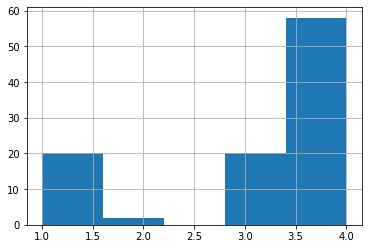

In [ ]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 5)

In [ ]:
# Based on the histogram we are selecting the max len as 4
max_seq_len = 4

In [ ]:
########Tokenize input######
tokens_train = tokenizer(train_text.tolist(),
                         max_length=max_seq_len,
                         pad_to_max_length=True,
                         truncation=True,
                         return_token_type_ids=False)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
class BERT_Arch(nn.Module):
   def __init__(self, bert):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,5)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)
      return x

In [ ]:
# To get model summary
!pip install torchinfo

In [ ]:
#freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             (85,054,464)
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linea

In [ ]:
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# #compute the class weights
# class_wts = compute_class_weight(‘balanced’, np.unique(train_labels), train_labels)
# print(class_wts)
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)
# # loss function
# cross_entropy = nn.NLLLoss(weight=weights)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# #compute the class weights
# class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)
# print(class_wts)
# # convert class weights to tensor

# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)
# loss function
cross_entropy = nn.NLLLoss()

In [ ]:
from torch.optim import lr_scheduler 
# empty lists to store training and validation loss of each epoch
train_losses=[]
training_acc = []
# number of training epochs
epochs = 50
# We can also use learning rate scheduler to achieve better results
lr_sch = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [ ]:
# function to train the model
def train():
  
  model.train()
  total_loss = 0
  avg_loss = 0

  correct = 0
  
  # empty list to save model predictions
  total_preds = 0
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    #if step % 50 == 0 and not step == 0:
      #print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    #calculate acc
    _, predicted = torch.max(preds, 1)
    correct += (predicted == labels).float().sum()

    
    # clear calculated gradients
    optimizer.zero_grad()
  
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # We are not using learning rate scheduler as of now
    # lr_sch.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    #total_preds.append(preds)
    total_preds += len(labels)
    # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  accuracy = 100 * correct / total_preds
    #print(accuracy)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, accuracy

In [ ]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, acc = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
#print(f'\nTraining Loss: {train_loss:.3f}')
    #print('Training Loss: ', train_loss)
    print('Training_loss: {} / Training Accuracy: {}'.format(train_loss, acc))


 Epoch 1 / 50
Training_loss: 0.10228875726949939 / Training Accuracy: 94.0

 Epoch 2 / 50
Training_loss: 0.1360980167103532 / Training Accuracy: 94.0

 Epoch 3 / 50
Training_loss: 0.10558888635465051 / Training Accuracy: 95.0

 Epoch 4 / 50
Training_loss: 0.12868462236864225 / Training Accuracy: 93.0

 Epoch 5 / 50
Training_loss: 0.09340531458396331 / Training Accuracy: 96.0

 Epoch 6 / 50
Training_loss: 0.09021519473909782 / Training Accuracy: 96.0

 Epoch 7 / 50
Training_loss: 0.09359480465562749 / Training Accuracy: 95.0

 Epoch 8 / 50
Training_loss: 0.08584428312523025 / Training Accuracy: 96.0

 Epoch 9 / 50
Training_loss: 0.10470935359314483 / Training Accuracy: 96.0

 Epoch 10 / 50
Training_loss: 0.1080637297460011 / Training Accuracy: 95.0

 Epoch 11 / 50
Training_loss: 0.10692728230994979 / Training Accuracy: 93.0

 Epoch 12 / 50
Training_loss: 0.12276852556637355 / Training Accuracy: 93.0

 Epoch 13 / 50
Training_loss: 0.0750232654333526 / Training Accuracy: 96.0

 Epoch 14 

In [ ]:
def get_prediction(str):
 str = re.sub(r'[^a-zA-Z ]+', '', str)
 test_text = [str]
 model.eval()
 
 tokens_test_data = tokenizer(
 test_text,
 max_length = max_seq_len,
 pad_to_max_length=True,
 truncation=True,
 return_token_type_ids=False
 )
 test_seq = torch.tensor(tokens_test_data['input_ids'])
 test_mask = torch.tensor(tokens_test_data['attention_mask'])
 
 preds = None
 with torch.no_grad():
   preds = model(test_seq.to(device), test_mask.to(device))
 preds = preds.detach().cpu().numpy()
 preds = np.argmax(preds, axis = 1)
 print("Intent Identified: ", le.inverse_transform(preds)[0])
 return le.inverse_transform(preds)[0]
def get_response(message): 
  intent = get_prediction(message)
  for i in data['intents']: 
    if i["tag"] == intent:
      result = random.choice(i["responses"])
      break
  print(f"Response : {result}")
  return "Intent: "+ intent + '\n' + "Response: " + result

In [ ]:
get_response("see you later")

Intent Identified:  goodbye
Response : Speak soon!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'Intent: goodbye/nResponse: Speak soon!'